In [1]:
import matplotlib.pyplot as plt

import numpy as np

In [2]:
import vice
import arya

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [12]:
fiducial = surp.ViceModel.from_file("../../models/monash/K16_oob/model.json")

In [13]:
h = fiducial.history

In [14]:
t_end = np.max(h.time)

In [15]:
h_end = h[h.time == t_end]

# Star Formation History
Should go as the two part power law

In [16]:
def sfh_model(t, tau_sfh, tau_rise):
    return np.exp(-t/tau_sfh) * (1 - np.exp(-t/tau_rise))

In [17]:
tau_sfh_exp = np.vectorize(surp.simulation.star_formation_history.get_sfh_timescale)

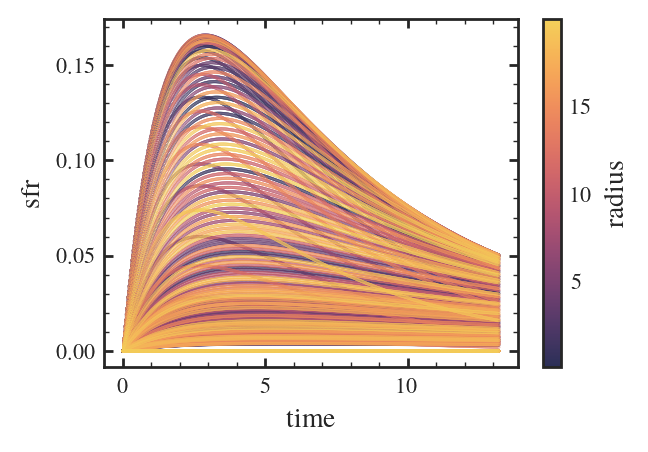

In [18]:
plt.scatter(h.time, h.sfr, c=h.R, s=0.01)
plt.xlabel("time")
plt.ylabel("sfr")
plt.colorbar(label="radius")

In [19]:
tau_sfh_exp(15.05)

array(35.95682)

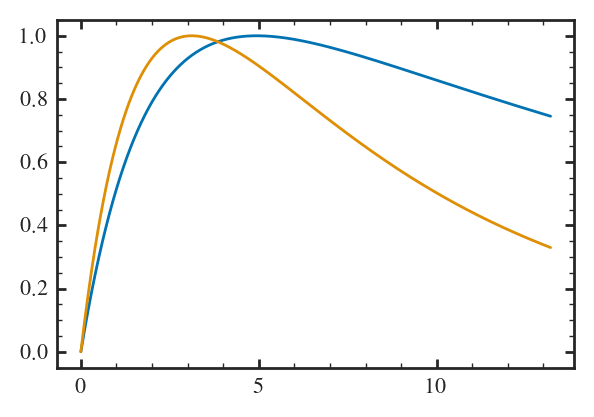

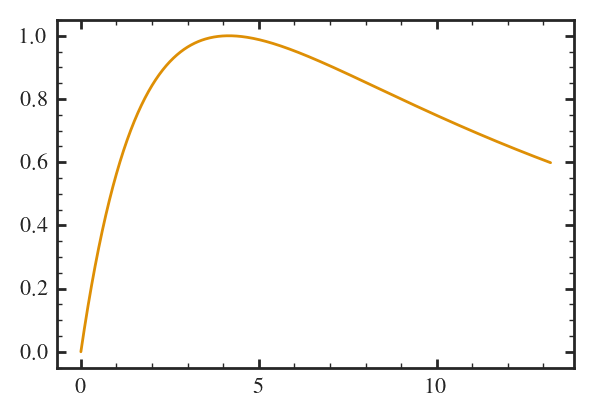

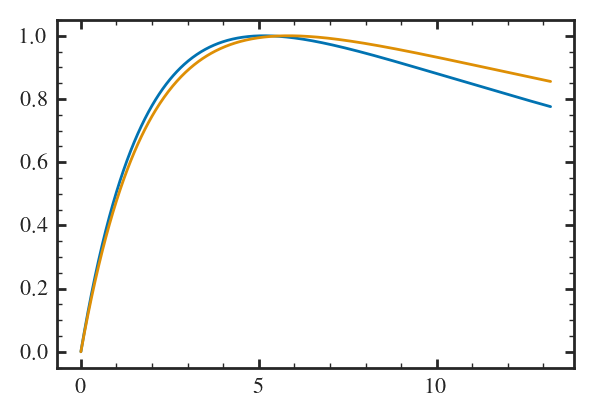

In [20]:
for R, tau_sfh in [(3.05, 7.5), (7.05, 14), (15.05, 35)]:
    tau_rise = 2
    filt = np.isclose(h.R, R)
    h1 = h[filt]
    plt.plot(h1.time, h1.sfr / np.max(h1.sfr))
    y = sfh_model(h1.time, tau_sfh, tau_rise)
    plt.plot(h1.time, y/np.max(y) )
    plt.show()

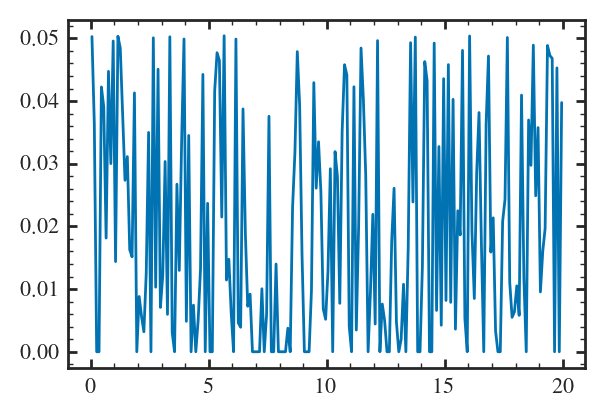

In [21]:
plt.plot(h_end.R, h_end.sfr)

In [22]:
dR = h_end.R[1] - h_end.R[0]

/tmp/ipykernel_1058067/243264679.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dR = h_end.R[1] - h_end.R[0]


Text(0.5, 0, 'R')

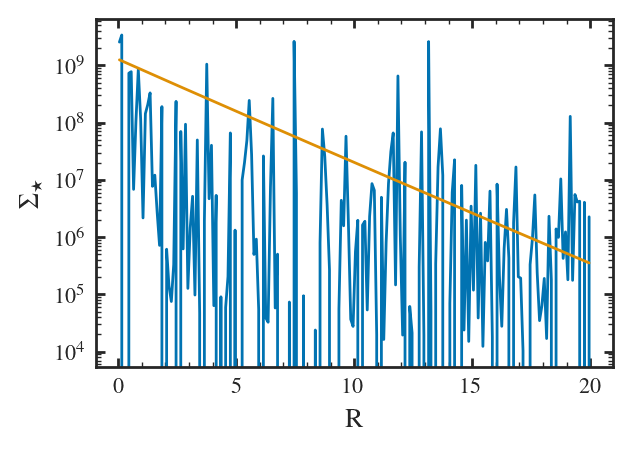

In [23]:
A = (2*np.pi * h_end.R * dR).values
plt.plot(h_end.R, h_end.mstar / A)
#plt.plot(h_end.R, h_end.mgas / A)

plt.yscale("log")
#plt.xscale("log")
plt.plot(h_end.R, 1e9*(np.exp(-h_end.R / 2.5) + 0.27*np.exp(-h_end.R / 2.0)))
plt.ylabel(r"$\Sigma_\star$")
plt.xlabel("R")


star formation densities are okay. divergence at centre is likely a result of migration but may not even be that unphysical.

In [24]:
print("%0.2e" % np.sum(h_end.mstar)) # total mass should be 5.17 x 10^10 solar masses

5.34e+10


# SFR Law

In [25]:
def KS_law(Σg):
    # sfr density as a function of gas mass
    Σ1 = 2e7
    Σ2 = 5e6
    γ1 = 1
    γ2 = 3.6
    γ3 = 1.7
    
    C1 = Σ2**(γ3 - γ2) * Σ1**(γ2 - γ1)
    C2 = Σ2**(γ3 - γ2)
    norm = 1/2.1 / C1

    s = 0
    s += np.where(Σ1 < Σgas , C1 * Σgas ** γ1, 0)
    s += np.where((Σ2 < Σgas) & (Σgas <= Σ1), C2 * Σgas ** γ2, 0)
    s += np.where(Σgas <= Σ2, Σgas**γ3, 0)
    return norm*s

In [26]:
Σgas = h_end.mgas/A

1/(h_end.sfr / A / Σgas * 1e9)[np.isclose(h_end.R, 7.05)]

46930    inf
dtype: float64

In [27]:
tau_star[np.argmin(np.abs(h_end.R - 8.12))]

NameError: name 'tau_star' is not defined

(1.0, 25.682405150543932)

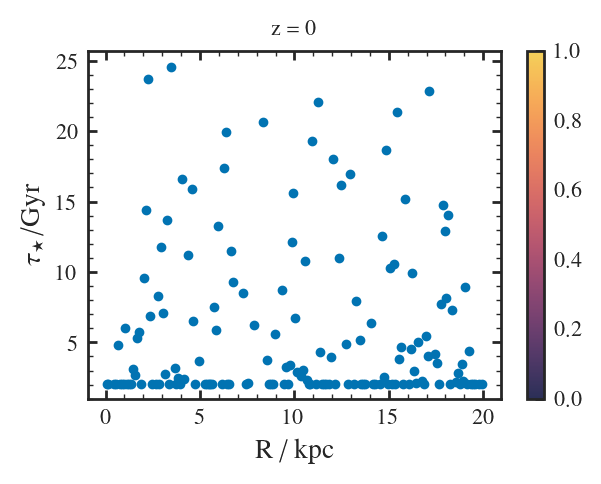

In [28]:
Σgas = h_end.mgas/A
yr_per_Gyr = 1e9
tau_star = h_end.mgas /(h_end.sfr * yr_per_Gyr)
plt.scatter(h_end.R, tau_star)
plt.colorbar()
Σgas = np.linspace(1e6, 1e9, 1000)
plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_\star\,$/Gyr")
plt.title("z = 0")
plt.ylim(1)


In [29]:
min(tau_star)

2.070296404361031

In [30]:
from scipy.optimize import curve_fit

def lin(x, a, b):
    return a*x + b

filt = h_end.R < 12

tau_star_0 = 2
popt, covt = curve_fit(lin, h_end.R[filt], tau_star_0 / tau_sfh[filt])

TypeError: 'int' object is not subscriptable

NameError: name 'popt' is not defined

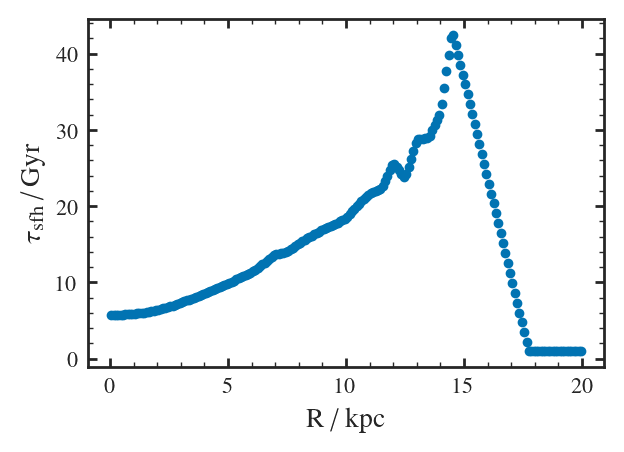

In [31]:
tau_sfh = tau_sfh_exp(h_end.R)
plt.scatter(h_end.R, tau_sfh)

plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_{\rm sfh}\,/\,\rm Gyr$")

plt.plot(h_end.R, 2/lin(h_end.R, *popt))
plt.ylim(0, 30)

In [ ]:
tau_sfh = tau_sfh_exp(h_end.R)
plt.scatter(h_end.R, np.array(tau_star) /tau_sfh)

plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_\star / \tau_{\rm sfh}$")

plt.plot(h_end.R, lin(h_end.R, *popt))

In [ ]:
Σgas = h_end.mgas/A
plt.scatter(Σgas, 1/(h_end.sfr / A / Σgas * 1e9), c=h_end.R, zorder=5)
plt.colorbar()
Σgas = np.linspace(1e6, 1e9, 1000)
plt.scatter(Σgas, Σgas / KS_law(Σgas))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\tau_\star$")
plt.yscale("log")
plt.xscale('log')
plt.xlim(1e2)
plt.title("z = 0")
plt.ylim(1)


In [ ]:
np.log10(2)

In [32]:
def log_t_dep(log_z):
    At = 0.089
    Bt = -0.62
    return  Bt*log_z # ignoring offset

def t_dep_factor(z):
    return 10**log_t_dep(np.log10(1+z))

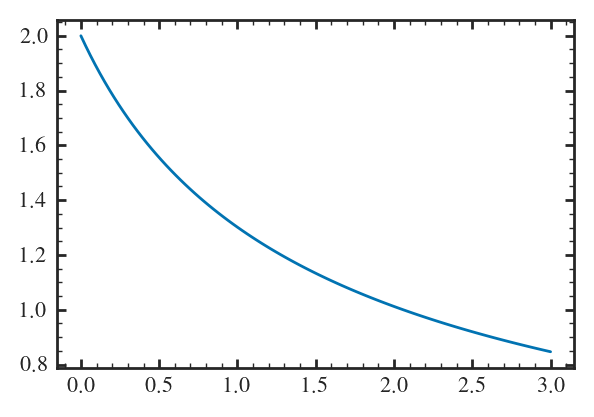

In [33]:
z = np.linspace(0, 3, 100)
plt.plot(z, t_dep_factor(z) * 2)


(100000.0, np.float64(74642858556.67685))

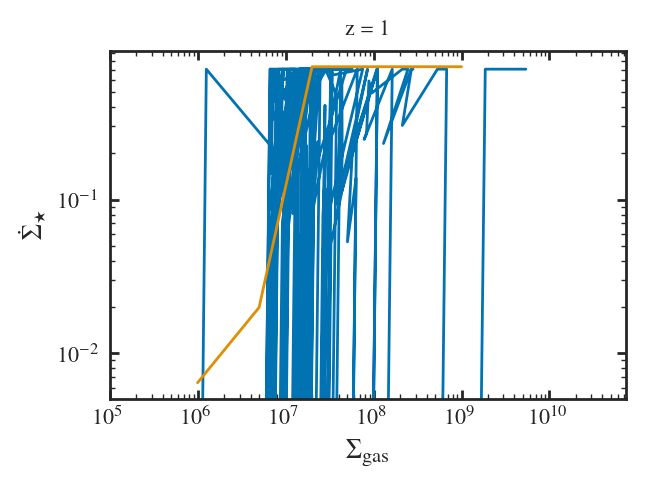

In [37]:
filt = np.isclose(h.time, 13.2 - 7.8)
h1 = h[filt]

Σgas = h1.mgas/A
plt.plot(Σgas, h1.sfr / A / Σgas * 1e9)
Σgas = np.linspace(1e6, 1e9, 1000)

plt.plot(Σgas, KS_law(Σgas)/ Σgas / t_dep_factor(1))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\dot{\Sigma}_\star$")
plt.yscale("log")
plt.xscale('log')
plt.title("z = 1")
plt.xlim(1e5)

(1, np.float64(64458919874.2668))

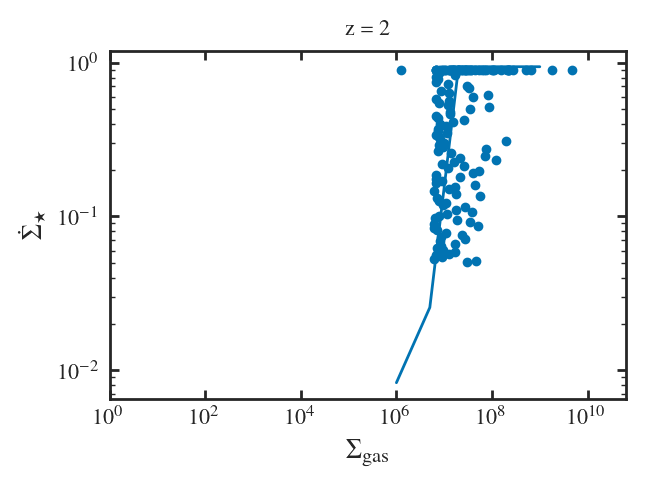

In [38]:
filt = np.isclose(h.time, 13.2 - 10.4)
h1 = h[filt]

Σgas = h1.mgas/A
plt.scatter(Σgas, h1.sfr / A / Σgas * 1e9)
Σgas = np.linspace(1e6, 1e9, 1000)

plt.plot(Σgas, KS_law(Σgas)/ Σgas /  t_dep_factor(2))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\dot{\Sigma}_\star$")
plt.yscale("log")
plt.xscale('log')
plt.title("z = 2")
plt.xlim(1)

ks law verified !!!

# Outflows and yields

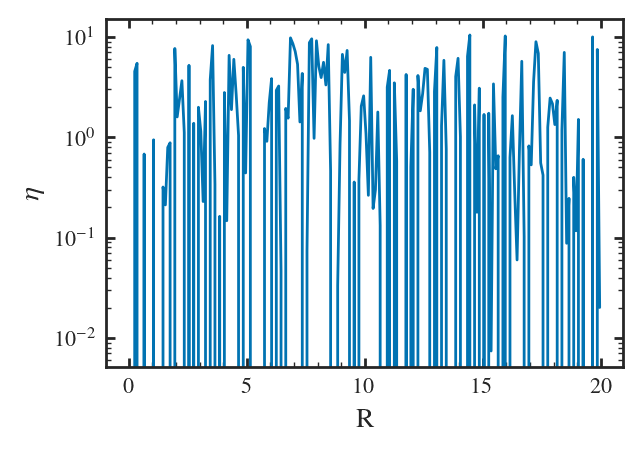

In [39]:
plt.plot(h_end.R, h_end.eta_0)
plt.xlabel("R")
plt.ylabel(r"$\eta$")
plt.yscale("log")

In [40]:
from surp.simulation.properties import MH_grad

ValidationError: 34 validation errors for MWParams
filename
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
zone_width
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
n_stars
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
simple
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
verbose
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
migration_mode
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
migration
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
sigma_R
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
save_migration
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
imf
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
timestep
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
t_d_ia
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
RIa
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
smoothing
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
tau_ia
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
m_upper
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
m_lower
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
sf_law
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
Re
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
sfh_model
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
sfh_kwargs
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
max_sf_radius
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
M_star_MW
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
thin_disk_scale_radius
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
thick_disk_scale_radius
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
thin_to_thick_ratio
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
r_sun
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
MH_grad_R0
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
MH_grad_MH0
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
MH_grad_in
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
MH_grad_out
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
eta_scale
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
r
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing
tau_star_sfh_grad
  Field required [type=missing, input_value=ArgsKwargs(()), input_type=ArgsKwargs]
    For further information visit https://errors.pydantic.dev/2.8/v/missing

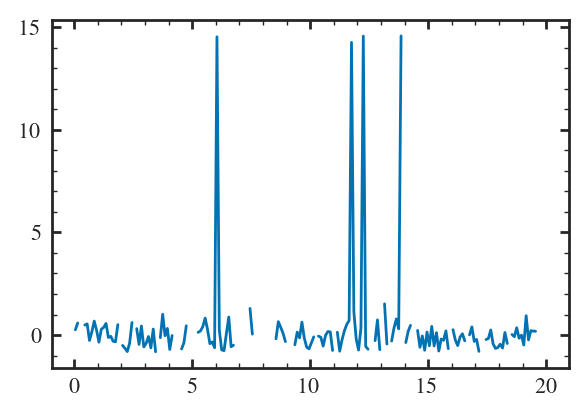

In [41]:
plt.plot(h_end.R, h_end.M_H)
y = MH_grad(params=surp.simulation.parameters.MWParams())(h_end.R)
plt.plot(h_end.R, y)

plt.xlim(0, 15)
plt.ylim(-0.7, 0.7)
plt.xlabel("R")
plt.ylabel(r"[M/H]")

In [ ]:
filt = h.R < 5
df = h[filt]
plt.scatter(df.time, df.MG_H, s=0.3, alpha=0.1, c=df.R)
plt.xlim(0, 15)
plt.ylim(-0.5, 0.5)
plt.colorbar()

# Migration

In [33]:
s = fiducial.stars_unsampled

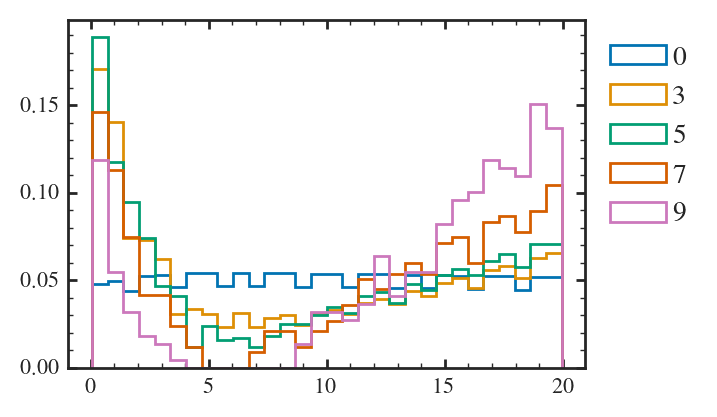

In [34]:
r_bins = [0, 3, 5, 7, 9, 13]
Nbins = len(r_bins) - 1
for i in range(Nbins):
    filt = s.r_final >= r_bins[i]
    filt &= s.r_final < r_bins[i+1]
    plt.hist(s[filt].r_origin, 30, histtype="step", density=True, label=r_bins[i])
arya.Legend(-1)

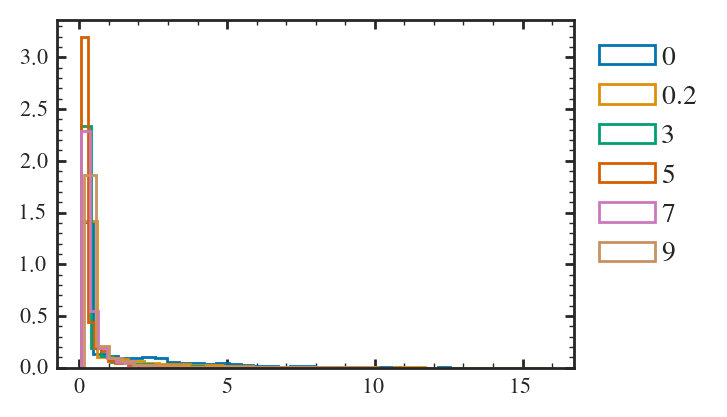

In [35]:
r_bins = [0, 0.2, 3, 5, 7, 9, 13]
Nbins = len(r_bins) - 1
for i in range(Nbins):
    filt = s.r_origin >= r_bins[i]
    filt &= s.r_origin < r_bins[i+1]
    plt.hist(s[filt].r_final, 30, histtype="step", density=True, label=r_bins[i])
arya.Legend(-1)

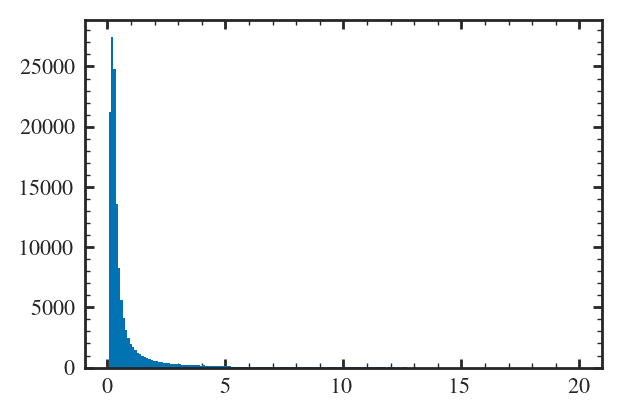

In [36]:
plt.hist(s.r_final, 200, ec="none");